# Data Loading and DataFrame/DataSeries Generation

We're going to load all the image data into an xarray data series object.  We'll also do some image manipulation to make sure everything is the same size (via downsampling), and we'll try to grab some metadata out of the DICOM info.  This might get trickier as future data may be 

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import SimpleITK as sitk
import sys, os
import numpy as np
from scipy import ndimage as ndi
import skimage as skim
from skimage import feature
import pandas as pd
import xarray as xr
plt.rcParams['figure.figsize'] = (10,8)
import os
import pickle as pkl
from skimage import morphology
import joypy
from mre.plotting import grid_plots
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
full_data_dir = '/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/MRE/'
subjects = sorted([x for x in os.listdir(full_data_dir) if x.isdigit()])
subdir_names = ['SE00001','SE00002','SE00003','SE00004','SE00005','SE00006']
sequence_labels = ['T2SS', 'T1Pre', 'T1Pos', 'T2FR', 'elastMsk', 'elast']
extras = ['extra0', 'extra1', 'extra2', 'extra3']

In [6]:
ds = pkl.load(open(full_data_dir+'mre_ds_preprocess_2.p', 'rb'))

In [16]:
ds['subject']

<xarray.DataArray 'subject' (subject: 50)>
array(['148', '162', '163', '178', '189', '195', '197', '218', '220', '222',
       '239', '264', '280', '289', '292', '295', '296', '299', '302', '331',
       '332', '343', '350', '351', '354', '357', '358', '360', '361', '363',
       '365', '368', '370', '371', '372', '375', '380', '381', '383', '386',
       '388', '391', '394', '396', '399', '402', '403', '404', '405', '406'],
      dtype='<U3')
Coordinates:
  * subject  (subject) <U3 '148' '162' '163' '178' ... '403' '404' '405' '406'

In [13]:
subj_list = ['365', '178']

In [14]:
ds.sel(dict(subject=subj_list))

<xarray.Dataset>
Dimensions:      (sequence: 10, subject: 2, x: 256, y: 256, z: 4)
Coordinates:
  * subject      (subject) <U3 '365' '178'
  * sequence     (sequence) <U8 'T1Pre' 'T1Pos' 'T2FR' ... 'extra2' 'extra3'
Dimensions without coordinates: x, y, z
Data variables:
    image        (subject, sequence, z, y, x) float32 4.0 4.0 5.0 ... 0.0 0.0
    age          (subject) int8 -27 -107
    z_space      (subject, sequence) float16 11.5 11.5 18.0 10.0 ... 0.0 0.0 0.0
    z_space_std  (subject) float16 2.854 1.2

In [15]:
ds.where(ds.z_space_std>3.5, drop=True)

<xarray.Dataset>
Dimensions:      (sequence: 10, subject: 3, x: 256, y: 256, z: 4)
Coordinates:
  * subject      (subject) <U3 '163' '399' '404'
  * sequence     (sequence) <U8 'T1Pre' 'T1Pos' 'T2FR' ... 'extra2' 'extra3'
Dimensions without coordinates: x, y, z
Data variables:
    image        (subject, sequence, z, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    age          (subject) float64 -91.0 53.0 5.0
    z_space      (subject, sequence) float16 11.5 20.0 20.0 20.0 ... 0.0 0.0 0.0
    z_space_std  (subject) float16 3.826 4.223 3.812

In [51]:
bad_subjs = ds.where(ds.z_space_std>3.5, drop=True).subject

In [52]:
ds.sel(subject = bad_subjs).z_space

<xarray.DataArray 'z_space' (subject: 3, sequence: 10)>
array([[11.5, 20. , 20. , 20. , 13. , 13. ,  0. ,  0. ,  0. ,  0. ],
       [ 9.2,  9.2,  9. , 20. , 11. , 11. ,  0. ,  0. ,  0. ,  0. ],
       [11.5, 11.5, 18. ,  6. , 11. , 11. ,  0. ,  0. ,  0. ,  0. ]],
      dtype=float16)
Coordinates:
  * subject   (subject) <U3 '163' '399' '404'
  * sequence  (sequence) <U8 'T1Pre' 'T1Pos' 'T2FR' ... 'extra2' 'extra3'

In [30]:
good_seq = ['T1Pre', 'T1Pos', 'T2SS', 'T2FR']
ds_tmp = ds.sel(sequence=good_seq, z=0)
grid_plots(ds_tmp, 'subject', 'sequence')

/home/bpollack/conda_envs/mre/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Text(0.5,0.98,'Subject 296')

/home/bpollack/conda_envs/mre/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


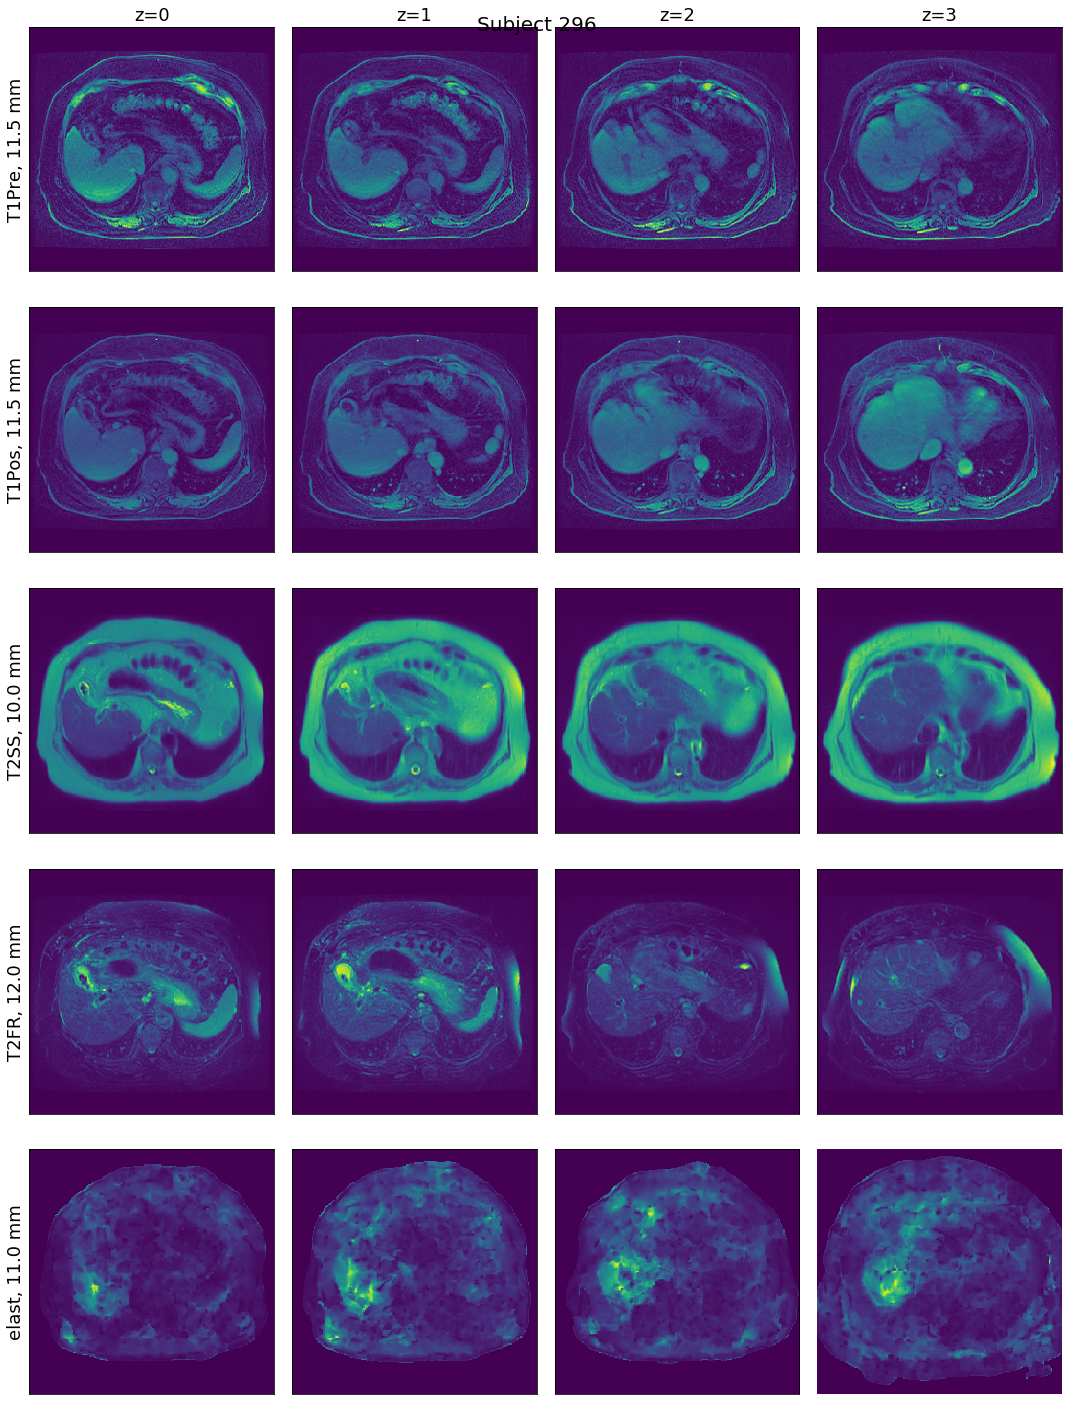

In [54]:
subj = '296'
ds_tmp = ds.sel(subject=subj, sequence=good_seq)
fig, axs = plt.subplots(len(ds_tmp.sequence), 4, tight_layout=True, figsize=(15,4*len(ds_tmp.sequence)), sharex=True, sharey=True)
plt.axis('off')
for i,seq in enumerate(ds_tmp.sequence):
    for z in range(4):
        axs[i][z].imshow(ds_tmp.sel(sequence=seq, z=z).image)
        #axs[i][z].axis('off')
        plt.xticks([])
        plt.yticks([])
        if i==0:
            axs[i][z].set_title(f'z={z}', size=18)
        if z==0:
            z_space = ds_tmp.sel(sequence=seq).z_space.values
            axs[i][z].set_ylabel(f'{seq.values}, {z_space:.01f} mm', size=18)
fig.suptitle(f'Subject {subj}', size=20)

In [6]:
df.head()

images  ages
sequence slices subject x y              
T2SS     0      365     0 0     0.0    58
                          1     0.0    58
                          2     0.0    58
                          3     0.0    58
                          4     0.0    58

In [7]:
df.drop(columns='ages', inplace=True)
df.rename(columns={'images':'pixels'}, inplace=True)
df = df.unstack(0)
df.columns = df.columns.droplevel()

In [8]:
df.head()

sequence            T1Pos  T1Pre  T2FR  T2SS  elast  elastMsk  msk
slices subject x y                                                
0      365     0 0    4.0    6.0   4.0   0.0    0.0       0.0  0.0
                 1    6.0    8.0   4.0   0.0    0.0       0.0  0.0
                 2    6.0    8.0   3.0   0.0    0.0       0.0  0.0
                 3    5.0    6.0   3.0   0.0    0.0       0.0  0.0
                 4    6.0    6.0   4.0   0.0    0.0       0.0  0.0

In [10]:
df.reset_index(inplace=True)

In [ ]:
df.hist

Text(0.5,0.98,'Pixel Dist for Subject 365')

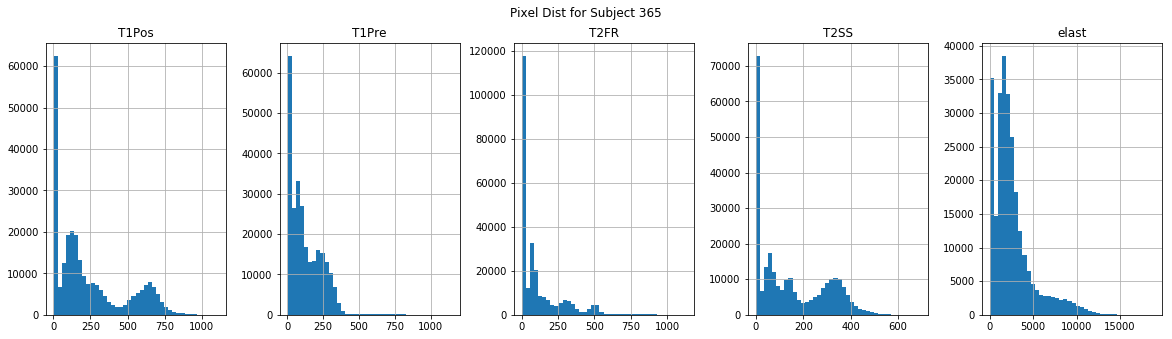

In [37]:
df.query('subject=="365"').hist(['T1Pos', 'T1Pre', 'T2FR', 'T2SS', 'elast'], figsize=(20,5), layout=(1,5), bins=40, sharey=True)
plt.suptitle('Pixel Dist for Subject 365')

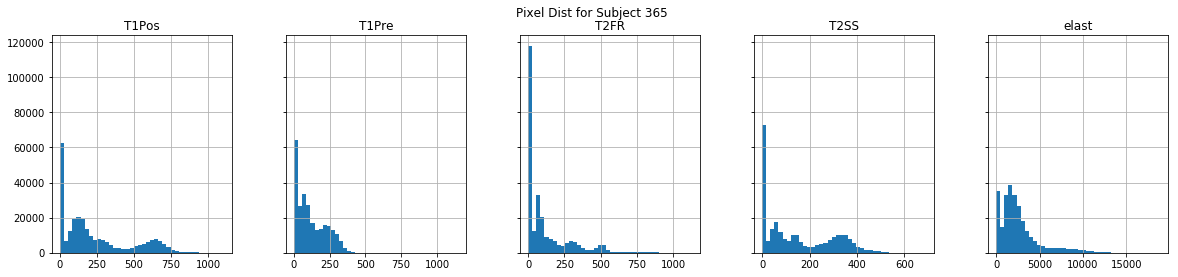

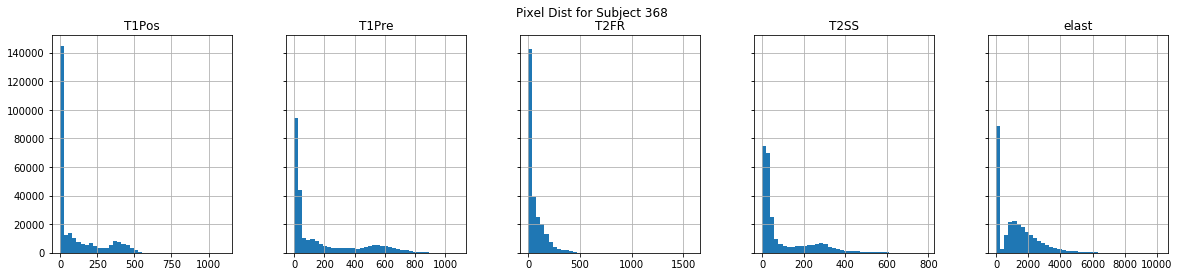

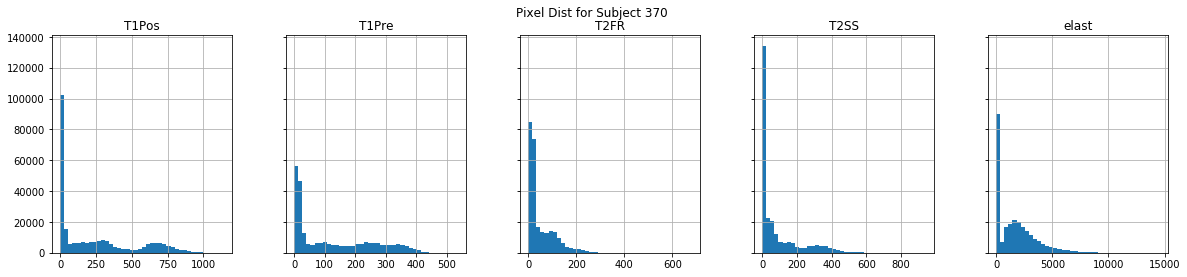

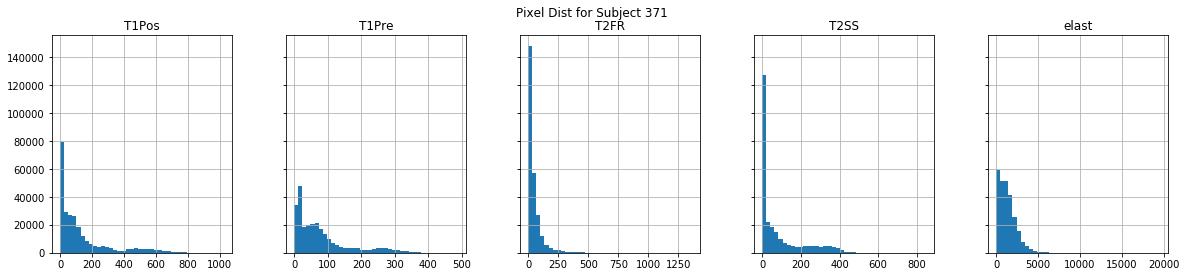

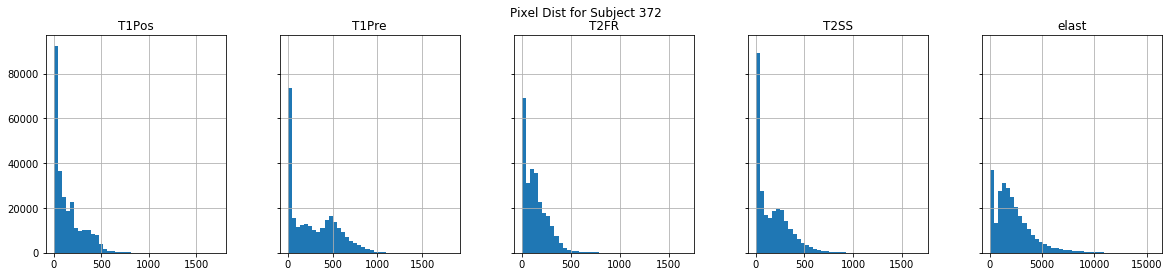

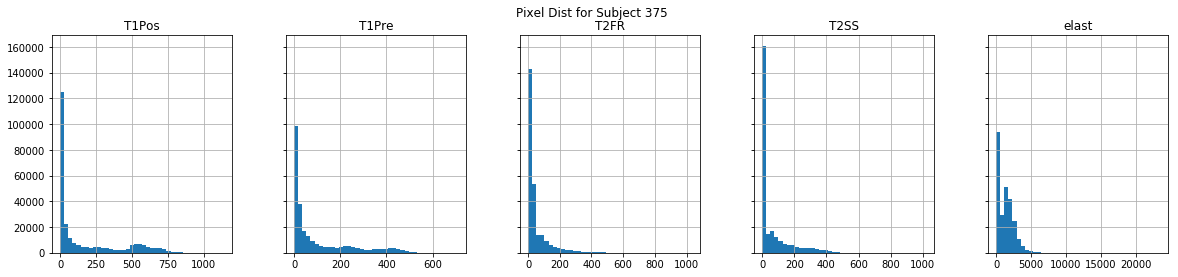

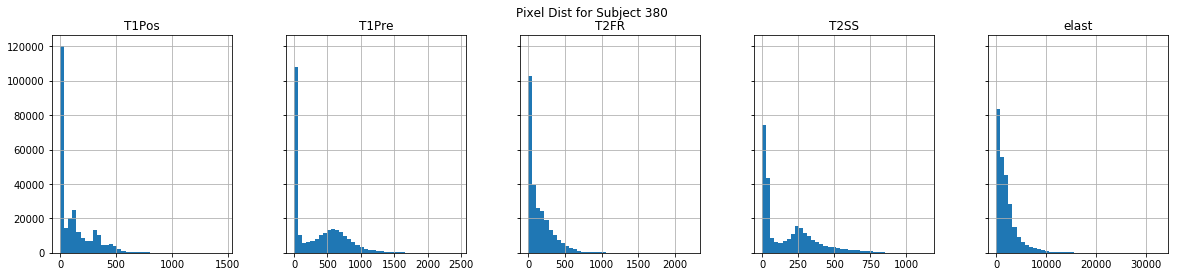

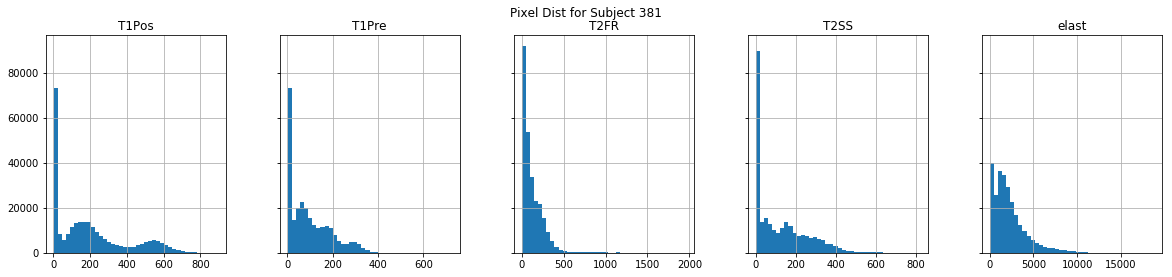

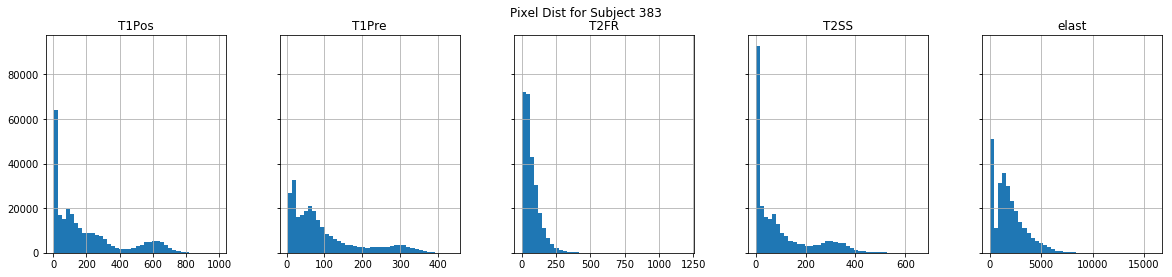

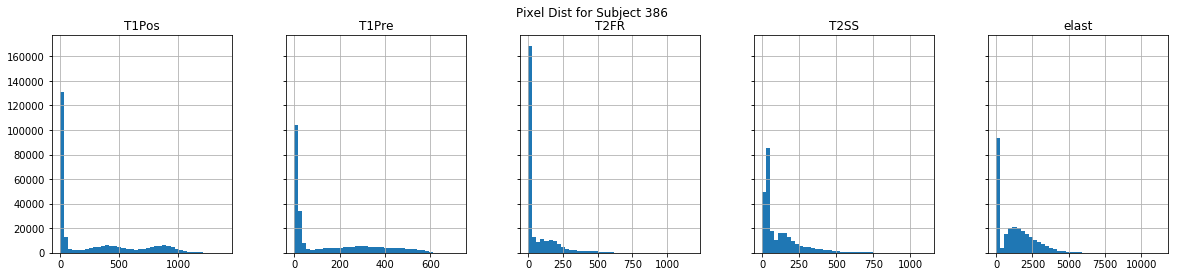

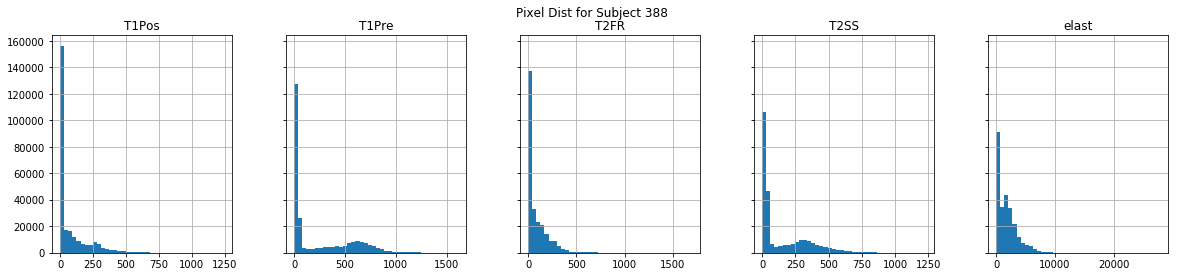

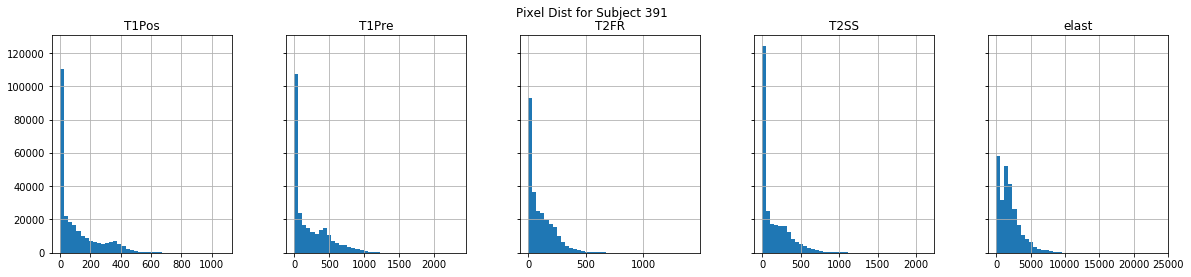

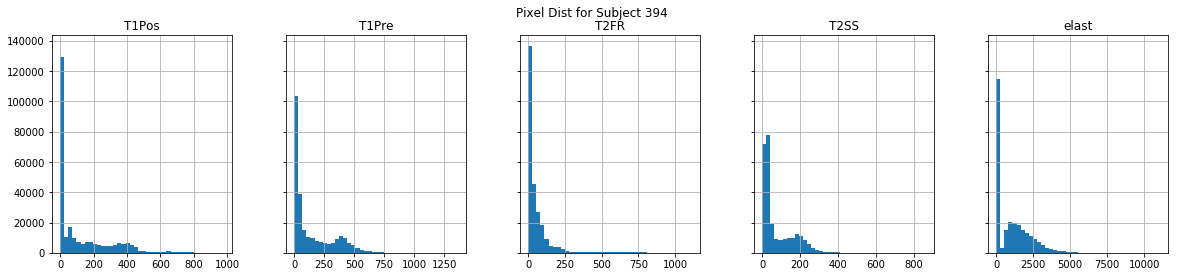

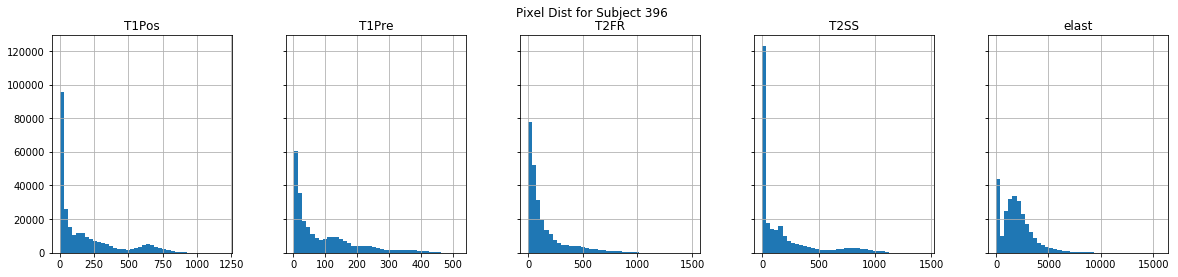

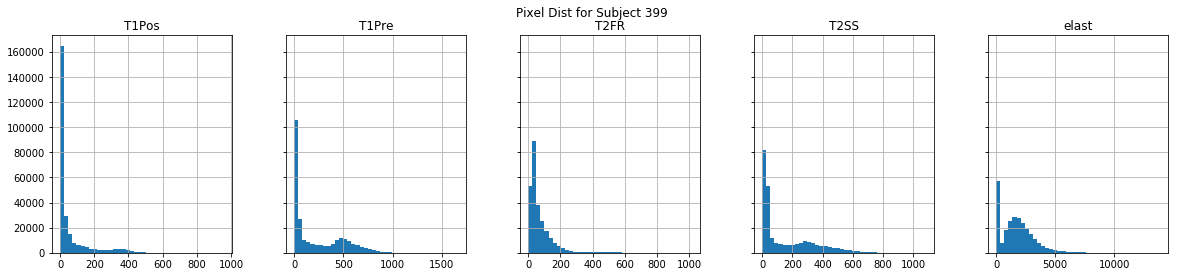

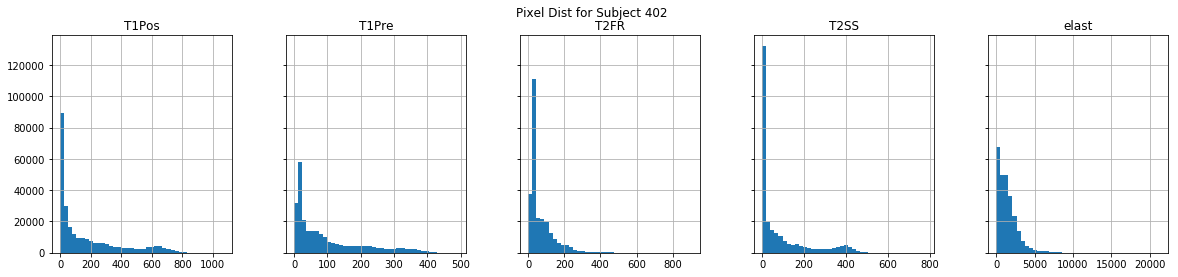

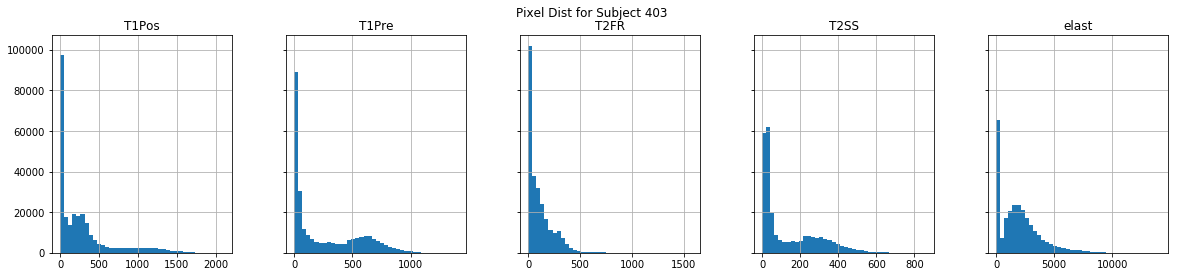

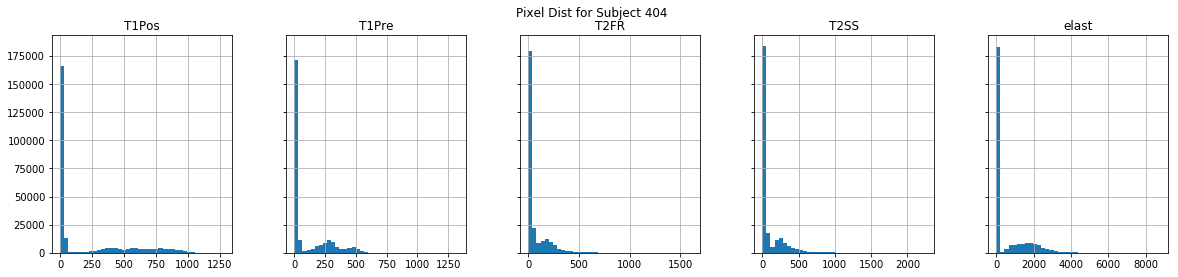

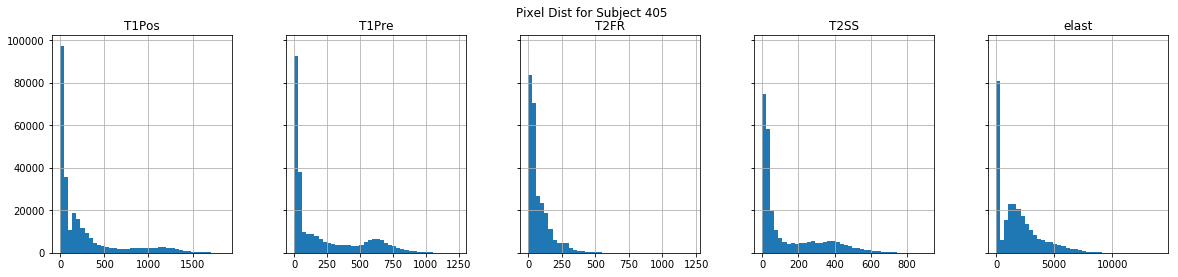

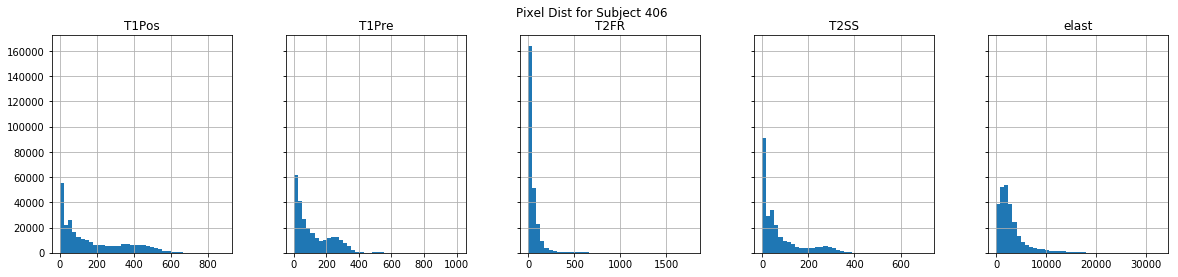

In [49]:
for subj in df.subject.unique():
    df.query(f'subject=="{subj}"').hist(['T1Pos', 'T1Pre', 'T2FR', 'T2SS', 'elast'], figsize=(20,4), layout=(1,5), bins=40, sharey=True)
    plt.suptitle(f'Pixel Dist for Subject {subj}')
    plt.show()


In [ ]:
df.fi

In [ ]:
import seaborn as sns
g = sns.FacetGrid(tips, row="subject", col="sequence", margin_titles=True)
g.map(plt.hist, "total_bill", color="steelblue", bins=bins)

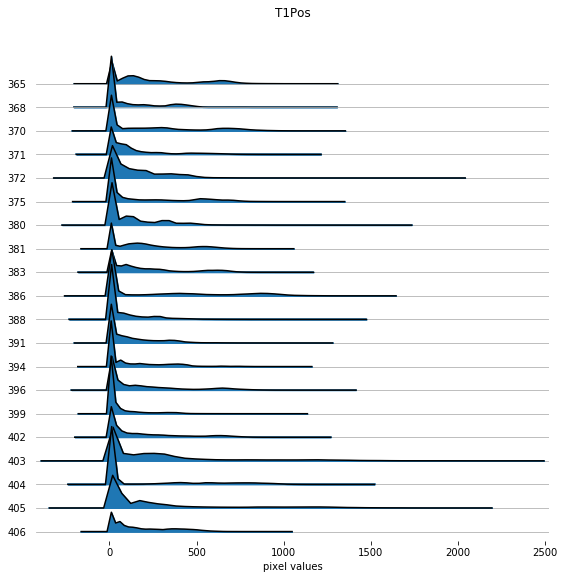

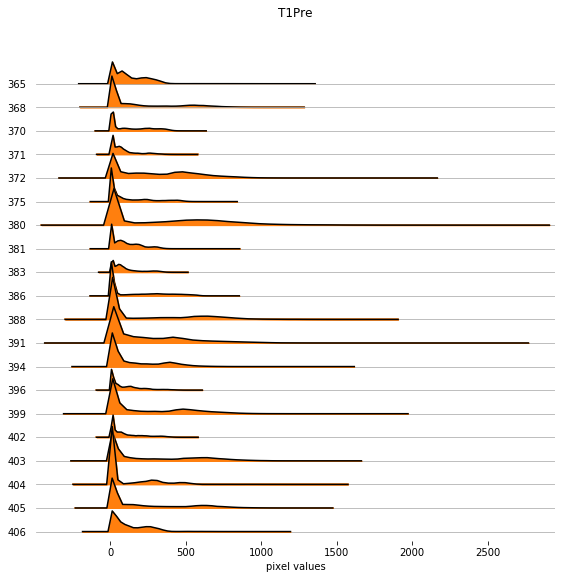

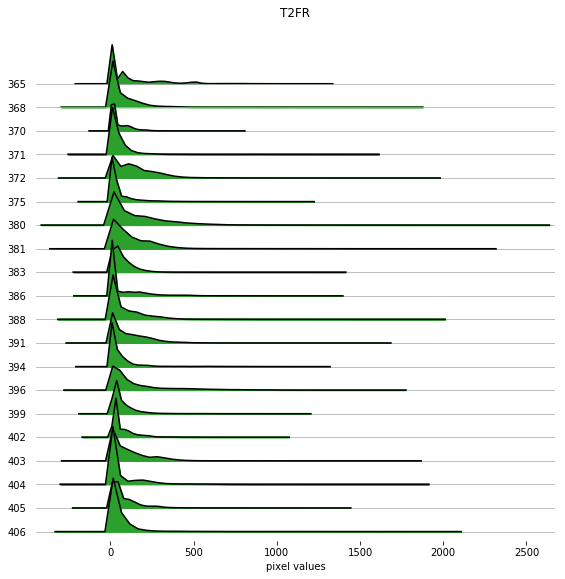

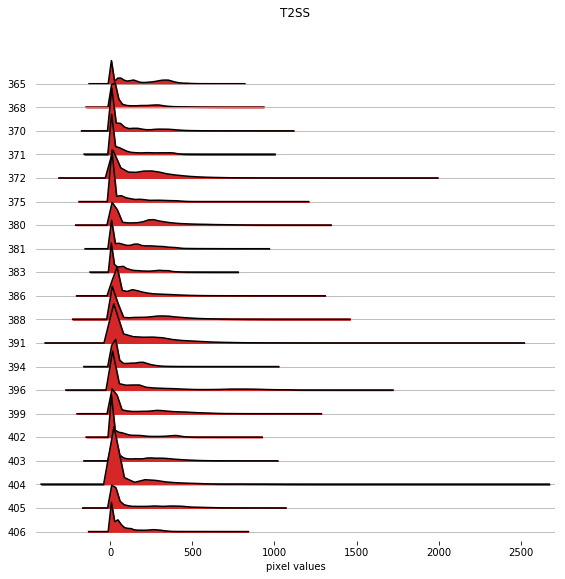

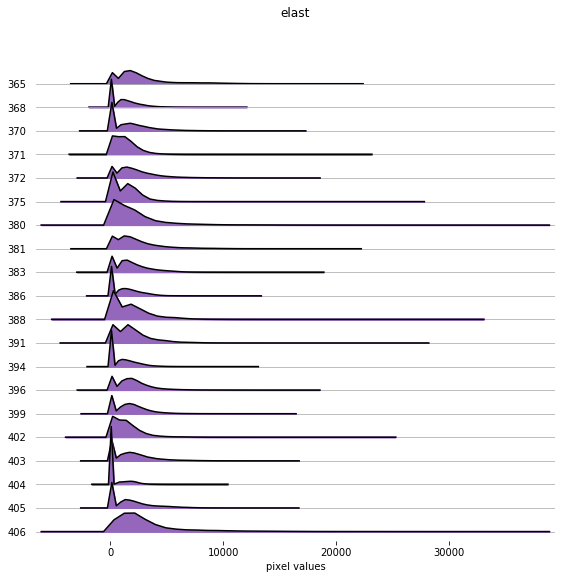

In [41]:
for i,col in enumerate(['T1Pos', 'T1Pre', 'T2FR', 'T2SS', 'elast']):
    fig, axes = joypy.joyplot(df, column=col, by='subject', range_style='own', kind='counts', bins=50,
                             title = col, color=f'C{i}', grid='y', figsize=(8,8))
    axes[-1].set_xlabel('pixel values')
    axes[-1].set_ylabel('subjects')
    plt.show()